In [1]:
##### DNN module

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2, l1_l2

#from sklearn.model_selection import train_test_split
#from keras import backend as K
#from keras.applications import ResNet50

Using TensorFlow backend.


In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
##### Common moldule

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time
from PIL import Image
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

In [4]:
##### Control Panel

fn_serial   = '018-A-139'
batch_size  = 24
num_classes = 5
epochs      = 100
pic_size    = 300
pool_size   = (2, 2)

In [5]:
##### Selection

Conv2D_size = [(3, 3), (5, 5), (7, 7)]
drop_out    = [0., 0.1]
l1_ratio    = [1e-4, 1e-8]
optimizer   = [Adam(lr=0.01),
               Adam(lr=0.001),
               RMSprop(lr=0.01),
               RMSprop(lr=0.001),
               SGD(lr=0.01, momentum=0.95),
               SGD(lr=0.001, momentum=0.95),
              ]

total_item = len(Conv2D_size) * len(drop_out) * len(l1_ratio) * len(optimizer)
print('Total config:', total_item)

Total config: 72


In [6]:
##### Note 

#Conv2D_size = [(3, 3), (5, 5), (7, 7)]
#drop_out    = [0., 0.1]
#l1_ratio    = [1e-4, 1e-8]
#optimizer   = [Adam(lr=0.01),
#               Adam(lr=0.001),
#               RMSprop(lr=0.01),
#               RMSprop(lr=0.001),
#               SGD(lr=0.01, momentum=0.95),
#               SGD(lr=0.001, momentum=0.95),
#              ]

# Good result:
# 0013 0103 0104 0113 0114 1013 1014 1015 1104 1105 1115 2004


In [7]:
def create_model(model_name, Conv2D_size, pic_size, l1_ratio, pool_size, drop_out_ratio):
    model = Sequential()
    model.name=model_name
    model.add(Conv2D(32, Conv2D_size, padding='same', input_shape=(pic_size, pic_size, 3), kernel_regularizer=l1(l1_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(128, Conv2D_size, padding='same', kernel_regularizer=l1(l1_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(64, Conv2D_size, padding='same', kernel_regularizer=l1(l1_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(32, Conv2D_size, padding='same', kernel_regularizer=l1(l1_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l1(l1_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(drop_out_ratio))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [8]:
def create_compile(optimizer):
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
def resampleRGI3d(input_mx, resize_to, dtype='float32'):
    # Ref: 10 3-A-7
    # Ver. 2.1
    # input_mx : numpy array, the original target matrix
    # resize_to: list or tuple with 3 int inside
    a, b, c = np.shape(input_mx)
    p, q, r = resize_to
    z_grid = np.linspace(0, p - 1, a)
    y_grid = np.linspace(0, q - 1, b)
    x_grid = np.linspace(0, r - 1, c)
    RGI = RegularGridInterpolator((z_grid, y_grid, x_grid), input_mx)
    z_grid_t2 = np.arange(p)
    y_grid_t2 = np.arange(q)
    x_grid_t2 = np.arange(r)
    meshgrid_para = np.meshgrid(z_grid_t2, y_grid_t2, x_grid_t2)
    RGI_mesh_mx = RGI((meshgrid_para[0], meshgrid_para[1], meshgrid_para[2]))
    RGI_mx = np.transpose(RGI_mesh_mx, axes=[1, 0, 2]).astype(dtype)
    return RGI_mx

def happy_time(start,stop):
    process_time = round(stop - start)
    ss = process_time % 60
    mm = process_time // 60 % 60
    hh = process_time // 3600
    duration = "Process time == {}s == {}H {}m {}s".format(process_time,hh,mm,ss)
    return duration

In [10]:
path_unknown = glob.glob('database/image_data/test/*')

In [11]:
unknown_dict = {}

for j in range(len(path_unknown)):
    serial = os.path.basename(path_unknown[j])[:-4]
    temp_pic = np.asarray(Image.open(path_unknown[j]))
    temp_pic = resampleRGI3d(temp_pic, (pic_size, pic_size, 3))
    temp_shape = np.shape(temp_pic)
    temp_pic = np.expand_dims(temp_pic, axis = 0)
    unknown_dict[serial] = temp_pic

print('Length of dict:', len(list(unknown_dict.keys())))

Length of dict: 2000


In [12]:
##### ImageDataGenerator

augment_generator = ImageDataGenerator(
                                       rotation_range=20,
                                       rescale=1./255,
                                       #featurewise_center=True,
                                       #featurewise_std_normalization=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True,
                                       #data_format='channels_last'
                                      )

In [13]:
##### Generator for train and validation

train_generator = augment_generator.flow_from_directory('database/image_data/sep_train',
                                                        target_size=(pic_size, pic_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
valid_generator = augment_generator.flow_from_directory('database/image_data/sep_valid',
                                                        target_size=(pic_size, pic_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
train_sample = train_generator.samples
valid_sample = valid_generator.samples

Found 2323 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
data batch shape: (24, 300, 300, 3)
labels batch shape: (24, 5)


Epoch 1/100
96/96 [==============================] - 44s 463ms/step - loss: 2.9109 - accuracy: 0.4002 - val_loss: 1.4314 - val_accuracy: 0.4000
Epoch 2/100
96/96 [==============================] - 48s 496ms/step - loss: 1.5644 - accuracy: 0.4854 - val_loss: 1.6788 - val_accuracy: 0.4181
Epoch 3/100
96/96 [==============================] - 47s 486ms/step - loss: 1.4975 - accuracy: 0.5059 - val_loss: 1.5900 - val_accuracy: 0.4475
Epoch 4/100
96/96 [==============================] - 46s 483ms/step - loss: 1.4261 - accuracy: 0.5428 - val_loss: 1.3740 - val_accuracy: 0.4412
Epoch 5/100
96/96 [==============================] - 44s 462ms/step - loss: 1.3733 - accuracy: 0.5441 - val_loss: 1.2844 - val_accuracy: 0.4433
Epoch 6/100
96/96 [==============================] - 44s 457ms/step - loss: 1.3859 - accuracy: 0.5459 - val_loss: 1.3507 - val_accuracy: 0.4895
Epoch 7/100
96/96 [==============================] - 43s 449ms/step - loss: 1.3130 - accuracy: 0.5803 - val_loss: 1.3743 - val_accuracy:

96/96 [==============================] - 39s 404ms/step - loss: 1.0072 - accuracy: 0.7005 - val_loss: 1.1244 - val_accuracy: 0.6261
Epoch 58/100
96/96 [==============================] - 39s 409ms/step - loss: 0.9783 - accuracy: 0.7031 - val_loss: 1.4588 - val_accuracy: 0.6155
Epoch 59/100
96/96 [==============================] - 39s 409ms/step - loss: 1.0199 - accuracy: 0.6960 - val_loss: 1.0545 - val_accuracy: 0.6366
Epoch 60/100
96/96 [==============================] - 40s 413ms/step - loss: 0.9785 - accuracy: 0.7047 - val_loss: 1.2064 - val_accuracy: 0.6450
Epoch 61/100
96/96 [==============================] - 39s 407ms/step - loss: 0.9978 - accuracy: 0.7029 - val_loss: 0.7397 - val_accuracy: 0.6555
Epoch 62/100
96/96 [==============================] - 40s 419ms/step - loss: 0.9971 - accuracy: 0.6853 - val_loss: 1.2180 - val_accuracy: 0.6870
Epoch 63/100
96/96 [==============================] - 40s 414ms/step - loss: 0.9561 - accuracy: 0.7196 - val_loss: 1.1066 - val_accuracy: 0.626

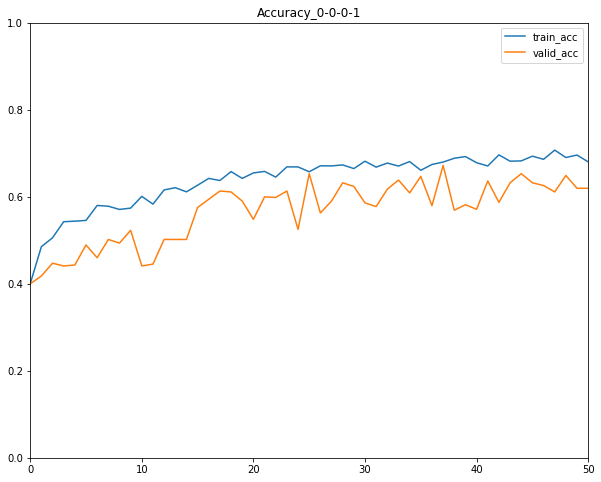

1/72, Model_0-0-0-1 done. Process time == 4103s == 1H 8m 23s
Epoch 1/100
96/96 [==============================] - 43s 448ms/step - loss: 1.7066 - accuracy: 0.3314 - val_loss: 1.4343 - val_accuracy: 0.4021
Epoch 2/100
96/96 [==============================] - 49s 511ms/step - loss: 1.2685 - accuracy: 0.4819 - val_loss: 1.2701 - val_accuracy: 0.4538
Epoch 3/100
96/96 [==============================] - 48s 495ms/step - loss: 1.1623 - accuracy: 0.5289 - val_loss: 1.2109 - val_accuracy: 0.4118
Epoch 4/100
96/96 [==============================] - 45s 469ms/step - loss: 1.0931 - accuracy: 0.5642 - val_loss: 1.5913 - val_accuracy: 0.5357
Epoch 5/100
96/96 [==============================] - 47s 490ms/step - loss: 1.0353 - accuracy: 0.5911 - val_loss: 1.3013 - val_accuracy: 0.4853
Epoch 6/100
96/96 [==============================] - 47s 488ms/step - loss: 1.0155 - accuracy: 0.6094 - val_loss: 1.1019 - val_accuracy: 0.5756
Epoch 7/100
96/96 [==============================] - 43s 445ms/step - loss:

96/96 [==============================] - 42s 439ms/step - loss: 0.6473 - accuracy: 0.7577 - val_loss: 0.7397 - val_accuracy: 0.7080
Epoch 58/100
96/96 [==============================] - 40s 421ms/step - loss: 0.6683 - accuracy: 0.7799 - val_loss: 1.0755 - val_accuracy: 0.7185
Epoch 59/100
96/96 [==============================] - 44s 461ms/step - loss: 0.6535 - accuracy: 0.7639 - val_loss: 0.7651 - val_accuracy: 0.6786
Epoch 60/100
96/96 [==============================] - 42s 442ms/step - loss: 0.6532 - accuracy: 0.7616 - val_loss: 0.8570 - val_accuracy: 0.6513
Epoch 61/100
96/96 [==============================] - 41s 425ms/step - loss: 0.6463 - accuracy: 0.7656 - val_loss: 1.1233 - val_accuracy: 0.6891
Epoch 62/100
96/96 [==============================] - 44s 453ms/step - loss: 0.6344 - accuracy: 0.7707 - val_loss: 0.7371 - val_accuracy: 0.6954
Epoch 63/100
96/96 [==============================] - 44s 456ms/step - loss: 0.6446 - accuracy: 0.7708 - val_loss: 0.8899 - val_accuracy: 0.691

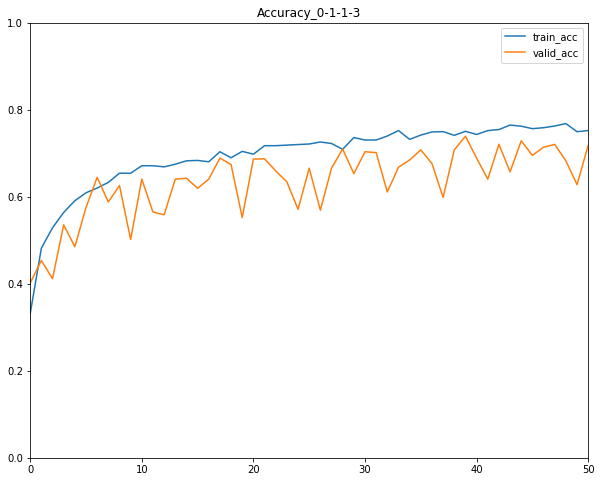

2/72, Model_0-1-1-3 done. Process time == 8432s == 2H 20m 32s
Epoch 1/100
96/96 [==============================] - 47s 487ms/step - loss: 1.5596 - accuracy: 0.3023 - val_loss: 1.6277 - val_accuracy: 0.1958
Epoch 2/100
96/96 [==============================] - 48s 500ms/step - loss: 1.5530 - accuracy: 0.3080 - val_loss: 1.4942 - val_accuracy: 0.3109
Epoch 3/100
96/96 [==============================] - 46s 482ms/step - loss: 1.5392 - accuracy: 0.3180 - val_loss: 1.6648 - val_accuracy: 0.2080
Epoch 4/100
96/96 [==============================] - 46s 477ms/step - loss: 1.5728 - accuracy: 0.2967 - val_loss: 1.7557 - val_accuracy: 0.2017
Epoch 5/100
96/96 [==============================] - 47s 488ms/step - loss: 1.5756 - accuracy: 0.2914 - val_loss: 1.6582 - val_accuracy: 0.1849
Epoch 6/100
96/96 [==============================] - 45s 465ms/step - loss: 1.5767 - accuracy: 0.2988 - val_loss: 1.8035 - val_accuracy: 0.2080
Epoch 7/100
96/96 [==============================] - 43s 447ms/step - loss

96/96 [==============================] - 42s 437ms/step - loss: 1.5816 - accuracy: 0.2779 - val_loss: 1.6747 - val_accuracy: 0.2101
Epoch 58/100
96/96 [==============================] - 41s 422ms/step - loss: 1.5643 - accuracy: 0.3075 - val_loss: 1.6197 - val_accuracy: 0.2122
Epoch 59/100
96/96 [==============================] - 41s 423ms/step - loss: 1.5773 - accuracy: 0.2845 - val_loss: 1.7204 - val_accuracy: 0.1933
Epoch 60/100
96/96 [==============================] - 42s 441ms/step - loss: 1.5728 - accuracy: 0.2936 - val_loss: 1.6319 - val_accuracy: 0.1933
Epoch 61/100
96/96 [==============================] - 41s 431ms/step - loss: 1.5657 - accuracy: 0.3093 - val_loss: 1.6783 - val_accuracy: 0.2059
Epoch 62/100
96/96 [==============================] - 41s 425ms/step - loss: 1.5769 - accuracy: 0.2921 - val_loss: 1.6357 - val_accuracy: 0.2017
Epoch 63/100
96/96 [==============================] - 42s 438ms/step - loss: 1.5686 - accuracy: 0.2995 - val_loss: 1.7073 - val_accuracy: 0.197

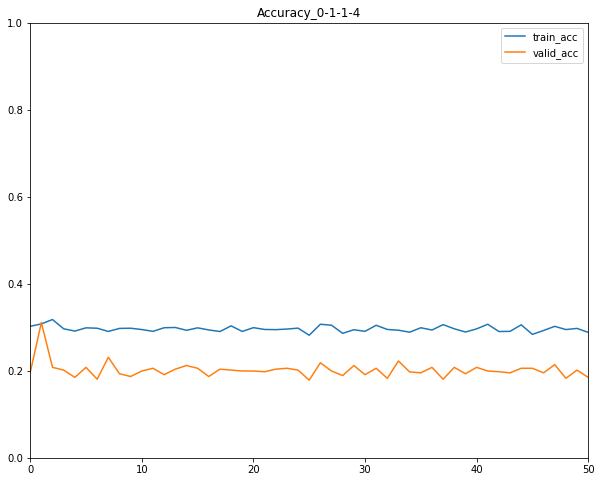

3/72, Model_0-1-1-4 done. Process time == 12638s == 3H 30m 38s
Epoch 1/100
96/96 [==============================] - 43s 452ms/step - loss: 6.4141 - accuracy: 0.2827 - val_loss: 4.8351 - val_accuracy: 0.1937
Epoch 2/100
96/96 [==============================] - 49s 507ms/step - loss: 4.2874 - accuracy: 0.2980 - val_loss: 3.9598 - val_accuracy: 0.2143
Epoch 3/100
96/96 [==============================] - 48s 496ms/step - loss: 3.5666 - accuracy: 0.2940 - val_loss: 3.5021 - val_accuracy: 0.1996
Epoch 4/100
96/96 [==============================] - 49s 507ms/step - loss: 3.0957 - accuracy: 0.2940 - val_loss: 2.9422 - val_accuracy: 0.1954
Epoch 5/100
96/96 [==============================] - 48s 497ms/step - loss: 2.7596 - accuracy: 0.2984 - val_loss: 2.7425 - val_accuracy: 0.2101
Epoch 6/100
96/96 [==============================] - 45s 474ms/step - loss: 2.5195 - accuracy: 0.2932 - val_loss: 2.3532 - val_accuracy: 0.1849
Epoch 7/100
96/96 [==============================] - 47s 486ms/step - los

96/96 [==============================] - 45s 472ms/step - loss: 1.6364 - accuracy: 0.2940 - val_loss: 1.7177 - val_accuracy: 0.1954
Epoch 58/100
96/96 [==============================] - 42s 440ms/step - loss: 1.6350 - accuracy: 0.3034 - val_loss: 1.7351 - val_accuracy: 0.2059
Epoch 59/100
96/96 [==============================] - 42s 434ms/step - loss: 1.6345 - accuracy: 0.2904 - val_loss: 1.7700 - val_accuracy: 0.1891
Epoch 60/100
96/96 [==============================] - 44s 459ms/step - loss: 1.6326 - accuracy: 0.2975 - val_loss: 1.8762 - val_accuracy: 0.2017
Epoch 61/100
96/96 [==============================] - 43s 449ms/step - loss: 1.6343 - accuracy: 0.3010 - val_loss: 1.7857 - val_accuracy: 0.2059
Epoch 62/100
96/96 [==============================] - 41s 426ms/step - loss: 1.6339 - accuracy: 0.2984 - val_loss: 1.6410 - val_accuracy: 0.2122
Epoch 63/100
96/96 [==============================] - 44s 458ms/step - loss: 1.6365 - accuracy: 0.2871 - val_loss: 1.6889 - val_accuracy: 0.193

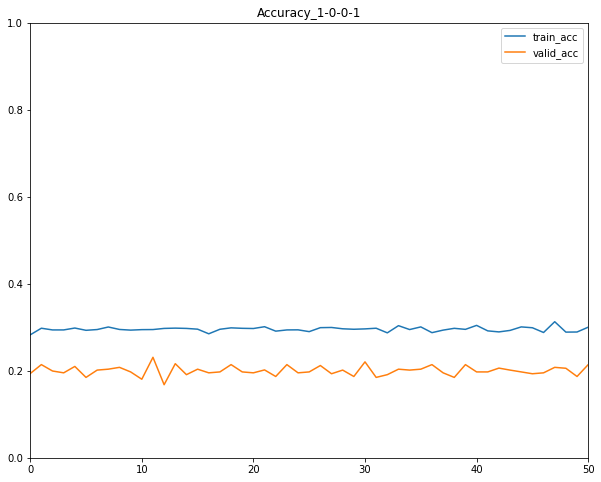

4/72, Model_1-0-0-1 done. Process time == 17001s == 4H 43m 21s
Epoch 1/100
96/96 [==============================] - 44s 453ms/step - loss: 3.4517 - accuracy: 0.3014 - val_loss: 1.5932 - val_accuracy: 0.2812
Epoch 2/100
96/96 [==============================] - 47s 492ms/step - loss: 1.4852 - accuracy: 0.4224 - val_loss: 1.3820 - val_accuracy: 0.4181
Epoch 3/100
96/96 [==============================] - 48s 497ms/step - loss: 1.2178 - accuracy: 0.5246 - val_loss: 1.2782 - val_accuracy: 0.3887
Epoch 4/100
96/96 [==============================] - 49s 506ms/step - loss: 1.1332 - accuracy: 0.5494 - val_loss: 0.9505 - val_accuracy: 0.5588
Epoch 5/100
96/96 [==============================] - 45s 468ms/step - loss: 1.0812 - accuracy: 0.5924 - val_loss: 0.8283 - val_accuracy: 0.5798
Epoch 6/100
96/96 [==============================] - 45s 472ms/step - loss: 1.0333 - accuracy: 0.6011 - val_loss: 0.9165 - val_accuracy: 0.5798
Epoch 7/100
96/96 [==============================] - 47s 488ms/step - los

96/96 [==============================] - 39s 411ms/step - loss: 0.9352 - accuracy: 0.6842 - val_loss: 1.1856 - val_accuracy: 0.5420
Epoch 58/100
96/96 [==============================] - 40s 414ms/step - loss: 1.0195 - accuracy: 0.6729 - val_loss: 1.0720 - val_accuracy: 0.5966
Epoch 59/100
96/96 [==============================] - 41s 431ms/step - loss: 0.8433 - accuracy: 0.6927 - val_loss: 1.1723 - val_accuracy: 0.6702
Epoch 60/100
96/96 [==============================] - 40s 417ms/step - loss: 0.8636 - accuracy: 0.6907 - val_loss: 0.6803 - val_accuracy: 0.6429
Epoch 61/100
96/96 [==============================] - 40s 416ms/step - loss: 0.8526 - accuracy: 0.6866 - val_loss: 1.5623 - val_accuracy: 0.5840
Epoch 62/100
96/96 [==============================] - 42s 437ms/step - loss: 1.0218 - accuracy: 0.6903 - val_loss: 1.1547 - val_accuracy: 0.6324
Epoch 63/100
96/96 [==============================] - 40s 412ms/step - loss: 0.9022 - accuracy: 0.7025 - val_loss: 0.8707 - val_accuracy: 0.708

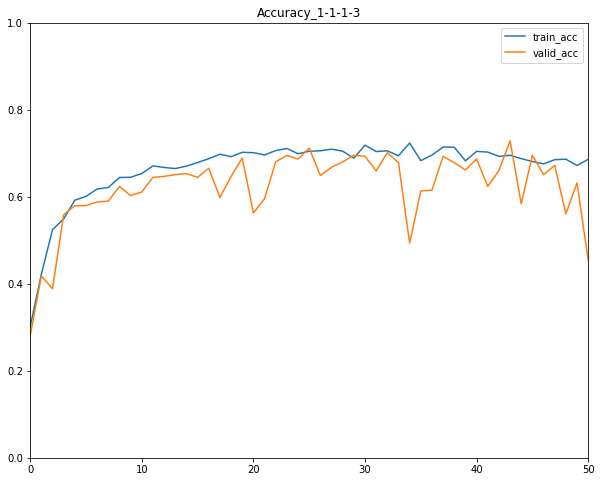

5/72, Model_1-1-1-3 done. Process time == 21202s == 5H 53m 22s
Epoch 1/100
96/96 [==============================] - 47s 485ms/step - loss: 1.5777 - accuracy: 0.2875 - val_loss: 1.6054 - val_accuracy: 0.2042
Epoch 2/100
96/96 [==============================] - 50s 525ms/step - loss: 1.5699 - accuracy: 0.2945 - val_loss: 1.6516 - val_accuracy: 0.1975
Epoch 3/100
96/96 [==============================] - 49s 511ms/step - loss: 1.5696 - accuracy: 0.3010 - val_loss: 1.6612 - val_accuracy: 0.1954
Epoch 4/100
96/96 [==============================] - 46s 480ms/step - loss: 1.5724 - accuracy: 0.2932 - val_loss: 1.5948 - val_accuracy: 0.1996
Epoch 5/100
96/96 [==============================] - 48s 503ms/step - loss: 1.5729 - accuracy: 0.2984 - val_loss: 1.6311 - val_accuracy: 0.2122
Epoch 6/100
96/96 [==============================] - 47s 489ms/step - loss: 1.5751 - accuracy: 0.2910 - val_loss: 1.5515 - val_accuracy: 0.1954
Epoch 7/100
96/96 [==============================] - 45s 469ms/step - los

96/96 [==============================] - 41s 423ms/step - loss: 1.5769 - accuracy: 0.2893 - val_loss: 1.6826 - val_accuracy: 0.1954
Epoch 58/100
96/96 [==============================] - 44s 456ms/step - loss: 1.5725 - accuracy: 0.2967 - val_loss: 1.5998 - val_accuracy: 0.2164
Epoch 59/100
96/96 [==============================] - 41s 432ms/step - loss: 1.5674 - accuracy: 0.3038 - val_loss: 1.5877 - val_accuracy: 0.1828
Epoch 60/100
96/96 [==============================] - 40s 420ms/step - loss: 1.5789 - accuracy: 0.2806 - val_loss: 1.6710 - val_accuracy: 0.2080
Epoch 61/100
96/96 [==============================] - 44s 456ms/step - loss: 1.5669 - accuracy: 0.3093 - val_loss: 1.5692 - val_accuracy: 0.2059
Epoch 62/100
96/96 [==============================] - 43s 444ms/step - loss: 1.5732 - accuracy: 0.2888 - val_loss: 1.6611 - val_accuracy: 0.1912
Epoch 63/100
96/96 [==============================] - 40s 421ms/step - loss: 1.5708 - accuracy: 0.2973 - val_loss: 1.6442 - val_accuracy: 0.199

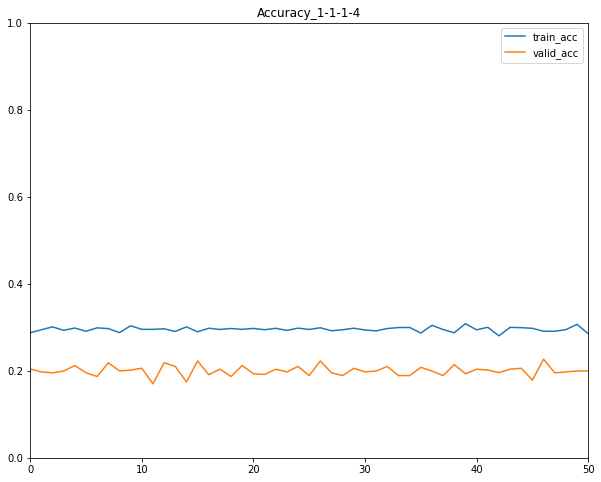

6/72, Model_1-1-1-4 done. Process time == 25568s == 7H 6m 8s
Epoch 1/100
96/96 [==============================] - 46s 476ms/step - loss: 9.0947 - accuracy: 0.2853 - val_loss: 5.5869 - val_accuracy: 0.2021
Epoch 2/100
96/96 [==============================] - 47s 492ms/step - loss: 5.1785 - accuracy: 0.2953 - val_loss: 4.9444 - val_accuracy: 0.2080
Epoch 3/100
96/96 [==============================] - 47s 485ms/step - loss: 4.7120 - accuracy: 0.2949 - val_loss: 4.6145 - val_accuracy: 0.1891
Epoch 4/100
96/96 [==============================] - 48s 496ms/step - loss: 4.3928 - accuracy: 0.2988 - val_loss: 4.4544 - val_accuracy: 0.1996
Epoch 5/100
96/96 [==============================] - 45s 472ms/step - loss: 4.1444 - accuracy: 0.2958 - val_loss: 4.0205 - val_accuracy: 0.2185
Epoch 6/100
96/96 [==============================] - 44s 459ms/step - loss: 3.9361 - accuracy: 0.2962 - val_loss: 4.0170 - val_accuracy: 0.1933
Epoch 7/100
96/96 [==============================] - 46s 475ms/step - loss:

96/96 [==============================] - 41s 431ms/step - loss: 1.7002 - accuracy: 0.2862 - val_loss: 1.8375 - val_accuracy: 0.2227
Epoch 58/100
96/96 [==============================] - 39s 407ms/step - loss: 1.6897 - accuracy: 0.3036 - val_loss: 1.6828 - val_accuracy: 0.1996
Epoch 59/100
96/96 [==============================] - 40s 417ms/step - loss: 1.6944 - accuracy: 0.2919 - val_loss: 1.8336 - val_accuracy: 0.1912
Epoch 60/100
96/96 [==============================] - 41s 427ms/step - loss: 1.6852 - accuracy: 0.2951 - val_loss: 1.7558 - val_accuracy: 0.1975
Epoch 61/100
96/96 [==============================] - 39s 410ms/step - loss: 1.6763 - accuracy: 0.3054 - val_loss: 1.7693 - val_accuracy: 0.1954
Epoch 62/100
96/96 [==============================] - 41s 427ms/step - loss: 1.6782 - accuracy: 0.2980 - val_loss: 1.7720 - val_accuracy: 0.2122
Epoch 63/100
96/96 [==============================] - 42s 435ms/step - loss: 1.6790 - accuracy: 0.2875 - val_loss: 1.7928 - val_accuracy: 0.199

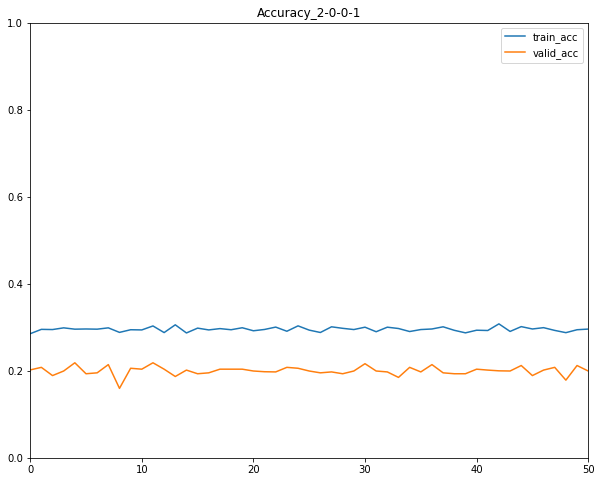

7/72, Model_2-0-0-1 done. Process time == 29754s == 8H 15m 54s
Epoch 1/100
96/96 [==============================] - 43s 445ms/step - loss: 5.3079 - accuracy: 0.2710 - val_loss: 1.5927 - val_accuracy: 0.2021
Epoch 2/100
96/96 [==============================] - 47s 492ms/step - loss: 1.6655 - accuracy: 0.3045 - val_loss: 1.7429 - val_accuracy: 0.2227
Epoch 3/100
96/96 [==============================] - 49s 511ms/step - loss: 1.5323 - accuracy: 0.3828 - val_loss: 1.3310 - val_accuracy: 0.3676
Epoch 4/100
96/96 [==============================] - 48s 497ms/step - loss: 1.4645 - accuracy: 0.4324 - val_loss: 1.2917 - val_accuracy: 0.4223
Epoch 5/100
96/96 [==============================] - 45s 472ms/step - loss: 1.2979 - accuracy: 0.4976 - val_loss: 1.4946 - val_accuracy: 0.4265
Epoch 6/100
96/96 [==============================] - 47s 492ms/step - loss: 1.2772 - accuracy: 0.5411 - val_loss: 0.9394 - val_accuracy: 0.5399
Epoch 7/100
96/96 [==============================] - 46s 479ms/step - los

96/96 [==============================] - 40s 416ms/step - loss: 0.8913 - accuracy: 0.6783 - val_loss: 0.8685 - val_accuracy: 0.6513
Epoch 58/100
96/96 [==============================] - 39s 407ms/step - loss: 1.2130 - accuracy: 0.6446 - val_loss: 1.3514 - val_accuracy: 0.5063
Epoch 59/100
96/96 [==============================] - 40s 414ms/step - loss: 0.8831 - accuracy: 0.6970 - val_loss: 0.9907 - val_accuracy: 0.6450
Epoch 60/100
96/96 [==============================] - 40s 414ms/step - loss: 0.9272 - accuracy: 0.6577 - val_loss: 1.0257 - val_accuracy: 0.6008
Epoch 61/100
96/96 [==============================] - 39s 409ms/step - loss: 0.9048 - accuracy: 0.6726 - val_loss: 1.8886 - val_accuracy: 0.4853
Epoch 62/100
96/96 [==============================] - 40s 416ms/step - loss: 1.0002 - accuracy: 0.6510 - val_loss: 0.9383 - val_accuracy: 0.6429
Epoch 63/100
96/96 [==============================] - 40s 414ms/step - loss: 1.2365 - accuracy: 0.6546 - val_loss: 1.1245 - val_accuracy: 0.539

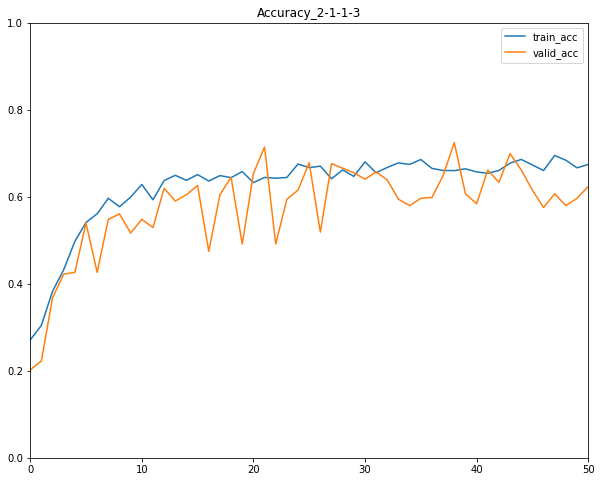

8/72, Model_2-1-1-3 done. Process time == 33947s == 9H 25m 47s
Epoch 1/100
96/96 [==============================] - 44s 461ms/step - loss: 1.5783 - accuracy: 0.2888 - val_loss: 1.6725 - val_accuracy: 0.2062
Epoch 2/100
96/96 [==============================] - 47s 492ms/step - loss: 1.5730 - accuracy: 0.2923 - val_loss: 1.6889 - val_accuracy: 0.1954
Epoch 3/100
96/96 [==============================] - 49s 509ms/step - loss: 1.5721 - accuracy: 0.2958 - val_loss: 1.6663 - val_accuracy: 0.1975
Epoch 4/100
96/96 [==============================] - 47s 488ms/step - loss: 1.5750 - accuracy: 0.2949 - val_loss: 1.6358 - val_accuracy: 0.2080
Epoch 5/100
96/96 [==============================] - 45s 467ms/step - loss: 1.5714 - accuracy: 0.2967 - val_loss: 1.5721 - val_accuracy: 0.2122
Epoch 6/100
96/96 [==============================] - 46s 484ms/step - loss: 1.5758 - accuracy: 0.2936 - val_loss: 1.5895 - val_accuracy: 0.1870
Epoch 7/100
96/96 [==============================] - 45s 472ms/step - los

96/96 [==============================] - 40s 413ms/step - loss: 1.5747 - accuracy: 0.2934 - val_loss: 1.6616 - val_accuracy: 0.1702
Epoch 58/100
96/96 [==============================] - 40s 420ms/step - loss: 1.5738 - accuracy: 0.2845 - val_loss: 1.7711 - val_accuracy: 0.2080
Epoch 59/100
96/96 [==============================] - 43s 448ms/step - loss: 1.5716 - accuracy: 0.2962 - val_loss: 1.6359 - val_accuracy: 0.2059
Epoch 60/100
96/96 [==============================] - 40s 412ms/step - loss: 1.5668 - accuracy: 0.3064 - val_loss: 1.7077 - val_accuracy: 0.1912
Epoch 61/100
96/96 [==============================] - 39s 411ms/step - loss: 1.5761 - accuracy: 0.2840 - val_loss: 1.6759 - val_accuracy: 0.2080
Epoch 62/100
96/96 [==============================] - 42s 439ms/step - loss: 1.5665 - accuracy: 0.3065 - val_loss: 1.6833 - val_accuracy: 0.1975
Epoch 63/100
96/96 [==============================] - 40s 418ms/step - loss: 1.5743 - accuracy: 0.2947 - val_loss: 1.6111 - val_accuracy: 0.201

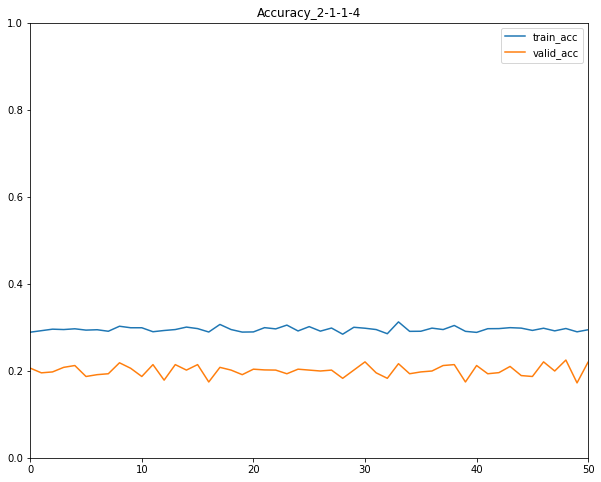

9/72, Model_2-1-1-4 done. Process time == 38194s == 10H 36m 34s


In [14]:
loop_start = time.time()
count = 0

for i in range(len(Conv2D_size)): #len(Conv2D_size)
    for j in range(len(drop_out)): #len(drop_out)
        for k in range(len(l1_ratio)): #len(l1_ratio)
            for m in range(len(optimizer)): #len(optimizer)
                if (j == 0) and (k == 0) and (m == 1): pass
                elif (j == 1) and (k == 1) and (m == 3): pass
                elif (j == 1) and (k == 1) and (m == 4): pass
                else: continue
                model_name = f'Model_{Conv2D_size[i]}-{drop_out[j]}-{l1_ratio[k]}-{optimizer[m]}'
                model = create_model(model_name, Conv2D_size[i], pic_size, l1_ratio[k], pool_size, drop_out[j])
                create_compile(optimizer[m])
                history = model.fit(train_generator, epochs=epochs, verbose=1,
                                    steps_per_epoch=int(train_sample/batch_size),
                                    validation_data=valid_generator,
                                    validation_steps=int(valid_sample/batch_size))
                id_li = []
                flower_class = []
                for n in range(len(list(unknown_dict.keys()))):
                    serial = list(unknown_dict.keys())[n]
                    pred = model.predict(unknown_dict[serial])[0]
                    id_li.append(serial)
                    flower_class.append(list(pred).index(max(pred)))
                    pred_result_df = pd.DataFrame(columns=['id', 'flower_class'])
                    pred_result_df['id'] = id_li
                    pred_result_df['flower_class'] = flower_class
                pred_result_df['flower_class'].value_counts().sort_index()
                pred_result_df.to_csv(f'model/FS_{fn_serial}/pred_result_FS_{i}-{j}-{k}-{m}.csv', index=False)
                train_acc = model.history.history["accuracy"]
                valid_acc = model.history.history["val_accuracy"]
                np.save(f'model/FS_{fn_serial}/History_{i}-{j}-{k}-{m}.npy', [train_acc, valid_acc])
                plt.figure(figsize=(10,8))
                plt.title(f'Accuracy_{i}-{j}-{k}-{m}')
                plt.ylim([0, 1])
                plt.xlim([0, 50])
                plt.plot(train_acc, label = 'train_acc')
                plt.plot(valid_acc, label = 'valid_acc')
                plt.legend()
                #plt.savefig(f'model/FS_{fn_serial}/Accuracy_{i}-{j}-{k}-{m}.png')
                #plt.clf()
                plt.show()
                count += 1
                print(f'{count}/{total_item}, Model_{i}-{j}-{k}-{m} done. {happy_time(loop_start, time.time())}')